## Parametric Modelling

In [1]:
from nilearn import plotting
%matplotlib inline
import os
import json
from nipype.interfaces import fsl 
from nipype.interfaces import spm
from nipype.interfaces.spm import (Realign, SliceTiming, Coregister,  NewSegment,  Normalize12, Smooth)
from nipype.interfaces.spm import Level1Design, EstimateModel, EstimateContrast
from nipype.algorithms.modelgen import SpecifySPMModel
from nipype.interfaces import matlab as mlab
from nipype.interfaces.io import SelectFiles, DataSink
import nipype.interfaces.utility as util 
from nipype.algorithms import rapidart as ra
from nipype.interfaces.utility import Function, IdentityInterface
import nipype.pipeline.engine as pe
import nipype.interfaces.io as nio
from nipype.interfaces.base import Bunch
from nipype import DataGrabber, Workflow, Node
from scipy.io.matlab import loadmat

In [2]:
# necessary to let nipype know about matlab path

In [3]:
spm.SPMCommand.set_mlab_paths(paths=os.path.abspath(os.path.join(os.environ['HOME'], 'Documents/MATLAB/spm12/')), matlab_cmd='/soft/matlab_hd/R2020b/bin/glnxa64/MATLAB -nodesktop -nosplash')

stty: 'standard input': Inappropriate ioctl for device


In [4]:
mlab.MatlabCommand.set_default_matlab_cmd("/soft/matlab_hd/R2020b/bin/glnxa64/MATLAB  -nodesktop -nosplash")
mlab.MatlabCommand.set_default_paths(os.path.abspath(os.path.join(os.environ['HOME'], 'Documents/MATLAB/spm12/')))

In [5]:
# spm.SPMCommand().version

In [6]:
fsl.FSLCommand.set_default_output_type('NIFTI')

In [7]:
base_dir = os.path.join(os.environ['HOME'], 'spmbasics/data/')

In [8]:
experiment_dir = os.path.join(base_dir, 'output')
data_dir = os.path.abspath(os.path.join(base_dir, 'face_rep'))
output_dir = 'nipype'
working_dir = 'workingdir'

# list of subject identifiers
subject_list = ['M03953']

# TR of functional images
TR = 2.


# Smoothing width used during preprocessing
fwhm = [8]

In [9]:
# add how to refer sots

In [10]:
#mat0 = mat = loadmat(os.path.join(data_dir, "sots.mat"), mat_dtype=True, matlab_compatible=True, struct_as_record=True)

In [11]:
#mat = loadmat(os.path.join(data_dir, "sots.mat"), mat_dtype=True, matlab_compatible=True, struct_as_record=True, simplify_cells=True)
#sot = mat['sot'][1]

#itemlag = mat['itemlag'][0]
#onsets=[sot[0], sot[1], sot[2], sot[3]],
# itemlag = mat['itemlag']

In [12]:
mat = loadmat(os.path.join(data_dir, "sots.mat"), struct_as_record=False, simplify_cells=True)
sot = mat['sot']
itemlag = mat['itemlag']

In [13]:
mat = loadmat(os.path.join(data_dir, "sots.mat"), struct_as_record=False, simplify_cells=True)
sot = mat['sot']
itemlag = mat['itemlag']
subjectinfo_param = [
    Bunch(
        conditions=['N1', 'N2', 'F1', 'F2'],
        onsets=[sot[0], sot[1], sot[2], sot[3]],
        durations=[[0], [0], [0], [0]],
        amplitudes=None,
        tmod=None,
        pmod=[
            None,
            Bunch(name=['Lag'], param=[itemlag[1].astype(dtype='float64').tolist()], poly=[2]),
            None,
            Bunch(name=['Lag'], param=[itemlag[3].astype(dtype='float64').tolist()], poly=[2])
        ],
        regressor_names=None,
        regressors=None)
]

In [14]:
# design matrix setting

In [15]:
cont1 = ('Famous_lag1', 'T', ['F2xLag^1'], [1]) # does not correspond to the design
cont2 = ('Famous_lag2', 'T', ['F2xLag^2'], [1])
fcont1 = ('Famous Lag', 'F', [cont1, cont2])
paramcontrasts = [cont1, cont2, fcont1]

In [16]:
# SpecifyModel - Generates SPM-specific Model
specmodel = Node(SpecifySPMModel(concatenate_runs=False,
                                 input_units='scans',
                                 output_units='scans',
                                 time_repetition=TR,
                                 high_pass_filter_cutoff=128,
                                 subject_info = subjectinfo_param),
                 name="specmodel")

# Level1Design - Generates an SPM design matrix same as the first level tutorial
eventparam = Node(Level1Design(bases={'hrf': {'derivs': [0, 0]}},
                                 timing_units='scans',
                                 interscan_interval=TR,
                                 volterra_expansion_order=1, # no model interction
                                 flags={'mthresh': 0.8},
                                 global_intensity_normalization='none',
                                 microtime_onset=12,
                                 microtime_resolution=24,
                                 #factor_info = [dict(name = 'Fame', levels = 2), # figure out factorized output names
                                 #               dict(name = 'Rep', levels = 2)],
                                 model_serial_correlations='AR(1)'), #matlabbatch{1}.spm.stats.fmri_spec.cvi = 'AR(1)';
                    name="eventparam")

# EstimateModel - estimate the parameters of the model
paramestimate = Node(EstimateModel(estimation_method={'Classical': 1}),
                      write_residuals=False, 
                      name="paramestimate")

# EstimateContrast - estimates contrasts
paramconest = Node(EstimateContrast(contrasts = paramcontrasts),
                    use_derivs=False, 
                    name="paramconest")

In [17]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id',
                                            'contrasts'],
                                    contrasts=paramcontrasts),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list)]


templates = {'func': os.path.join(output_dir, 'event_preproc', '_subject_id_{subject_id}',
                         'swars{subject_id}_0005_*.img'),#sM03953_0005_*.img
             'mc_param': os.path.join(output_dir, 'event_preproc', '_subject_id_{subject_id}',
                         'rp_s{subject_id}_0005_0006.txt')}
selectfiles = Node(SelectFiles(templates,
                               base_directory=experiment_dir,
                               sort_filelist=True),
                   name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

In [18]:
def makelist(item):
    return [item]

In [19]:
# Initiation of the 1st-level analysis workflow
event_param = Workflow(name='event_param')
event_param.base_dir = os.path.join(experiment_dir, working_dir)


In [20]:

# Connect up the 1st-level analysis components
event_param.connect([(infosource, selectfiles, [('subject_id', 'subject_id')]),
                    (infosource, paramconest, [('contrasts', 'contrasts')]),
                    (selectfiles, specmodel, [(('func', makelist),  'functional_runs')]), 
                    (selectfiles, specmodel, [('mc_param', 'realignment_parameters')]),
                    (specmodel, eventparam, [('session_info','session_info')]),
                    (eventparam, paramestimate, [('spm_mat_file','spm_mat_file')]),                    
                    (paramestimate, paramconest, [('spm_mat_file','spm_mat_file'),
                                                  ('beta_images','beta_images'),
                                                  ('residual_image', 'residual_image')]),
                    (paramestimate, datasink, [('mask_image','event_param.@mask_image'),
                                                    ('beta_images','event_param.@beta_images'),
                                                    ('residual_images','event_param.@residual_images'),
                                                    ('residual_image','event_param.@residual_image'),
                                                    ('RPVimage', 'event_param.@RPVimage')]), 
                    (paramconest, datasink, [('spm_mat_file', 'event_param.@spm_mat_file'),
                                              ('spmT_images', 'event_param.@spmT_images'),
                                              ('con_images', 'event_param.@con_images'),
                                              ('spmF_images', 'event_param.@spmF_images'),
                                              ('ess_images', 'event_param.@ess_images')]),
                    ])

In [21]:
event_param.write_graph(graph2use='colored', format='png', dotfilename='colored_param.dot', simple_form=True)

240528-11:25:16,86 nipype.workflow INFO:
	 Generated workflow graph: /home/matay/spmbasics/data/output/workingdir/event_param/colored_param.png (graph2use=colored, simple_form=True).


'/home/matay/spmbasics/data/output/workingdir/event_param/colored_param.png'

In [22]:
event_param.write_graph(graph2use='flat', format='png', dotfilename='flat_param.dot', simple_form=True)

240528-11:25:16,388 nipype.workflow INFO:
	 Generated workflow graph: /home/matay/spmbasics/data/output/workingdir/event_param/flat_param.png (graph2use=flat, simple_form=True).


'/home/matay/spmbasics/data/output/workingdir/event_param/flat_param.png'

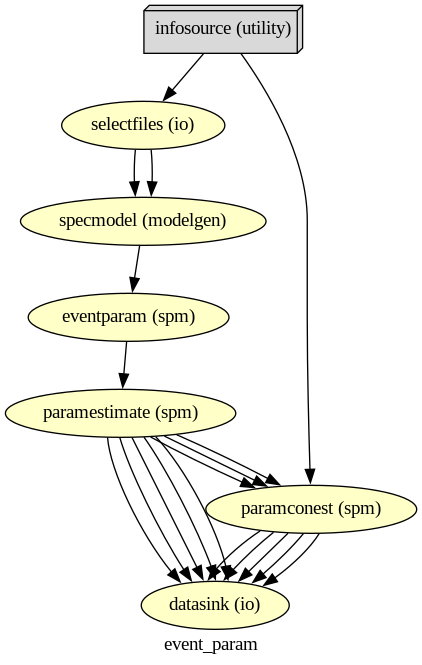

In [23]:
# Visualize the graph
from IPython.display import Image
Image(filename=os.path.join(event_param.base_dir, 'event_param', 'colored_param.png'))

In [24]:
event_param.run('MultiProc', plugin_args={'n_procs': 4})

240528-11:25:16,414 nipype.workflow INFO:
	 Workflow event_param settings: ['check', 'execution', 'logging', 'monitoring']
240528-11:25:16,419 nipype.workflow INFO:
	 Running in parallel.
240528-11:25:16,420 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 13.77/13.77, Free processors: 4/4.
240528-11:25:16,536 nipype.workflow INFO:
	 [Node] Setting-up "event_param.selectfiles" in "/home/matay/spmbasics/data/output/workingdir/event_param/_subject_id_M03953/selectfiles".
240528-11:25:16,548 nipype.workflow INFO:
	 [Node] Executing "selectfiles" <nipype.interfaces.io.SelectFiles>
240528-11:25:16,560 nipype.workflow INFO:
	 [Node] Finished "selectfiles", elapsed time 0.008597s.
240528-11:25:18,424 nipype.workflow INFO:
	 [Job 0] Completed (event_param.selectfiles).
240528-11:25:18,429 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 13.77/13.77, Free processors: 4/4.
240528-11:25:18,506 nipype.workflow INFO:
	 

stty: 'standard input': Inappropriate ioctl for device


240528-11:25:39,565 nipype.workflow INFO:
	 [Node] Finished "eventparam", elapsed time 12.496646s.


stty: 'standard input': Inappropriate ioctl for device


240528-11:25:40,446 nipype.workflow INFO:
	 [Job 2] Completed (event_param.eventparam).
240528-11:25:40,450 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 13.77/13.77, Free processors: 4/4.
240528-11:25:40,513 nipype.workflow INFO:
	 [Node] Setting-up "event_param.paramestimate" in "/home/matay/spmbasics/data/output/workingdir/event_param/_subject_id_M03953/paramestimate".
240528-11:25:40,520 nipype.workflow INFO:
	 [Node] Executing "paramestimate" <nipype.interfaces.spm.model.EstimateModel>
240528-11:25:42,447 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 0 jobs ready. Free memory (GB): 13.57/13.77, Free processors: 3/4.
                     Currently running:
                       * event_param.paramestimate


stty: 'standard input': Inappropriate ioctl for device


240528-11:26:02,825 nipype.workflow INFO:
	 [Node] Finished "paramestimate", elapsed time 15.812844s.


stty: 'standard input': Inappropriate ioctl for device


240528-11:26:04,469 nipype.workflow INFO:
	 [Job 3] Completed (event_param.paramestimate).
240528-11:26:04,474 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 13.77/13.77, Free processors: 4/4.
240528-11:26:04,534 nipype.workflow INFO:
	 [Node] Setting-up "event_param.paramconest" in "/home/matay/spmbasics/data/output/workingdir/event_param/_subject_id_M03953/paramconest".
240528-11:26:04,544 nipype.workflow INFO:
	 [Node] Executing "paramconest" <nipype.interfaces.spm.model.EstimateContrast>
240528-11:26:06,471 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 0 jobs ready. Free memory (GB): 13.57/13.77, Free processors: 3/4.
                     Currently running:
                       * event_param.paramconest


stty: 'standard input': Inappropriate ioctl for device


240528-11:26:22,282 nipype.workflow INFO:
	 [Node] Finished "paramconest", elapsed time 11.280577s.


stty: 'standard input': Inappropriate ioctl for device


240528-11:26:22,487 nipype.workflow INFO:
	 [Job 4] Completed (event_param.paramconest).
240528-11:26:22,491 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 13.77/13.77, Free processors: 4/4.
240528-11:26:22,576 nipype.workflow INFO:
	 [Node] Setting-up "event_param.datasink" in "/home/matay/spmbasics/data/output/workingdir/event_param/_subject_id_M03953/datasink".
240528-11:26:22,588 nipype.workflow INFO:
	 [Node] Executing "datasink" <nipype.interfaces.io.DataSink>
240528-11:26:22,594 nipype.workflow INFO:
	 [Node] Finished "datasink", elapsed time 0.003591s.
240528-11:26:24,490 nipype.workflow INFO:
	 [Job 5] Completed (event_param.datasink).
240528-11:26:24,494 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 0 jobs ready. Free memory (GB): 13.77/13.77, Free processors: 4/4.
